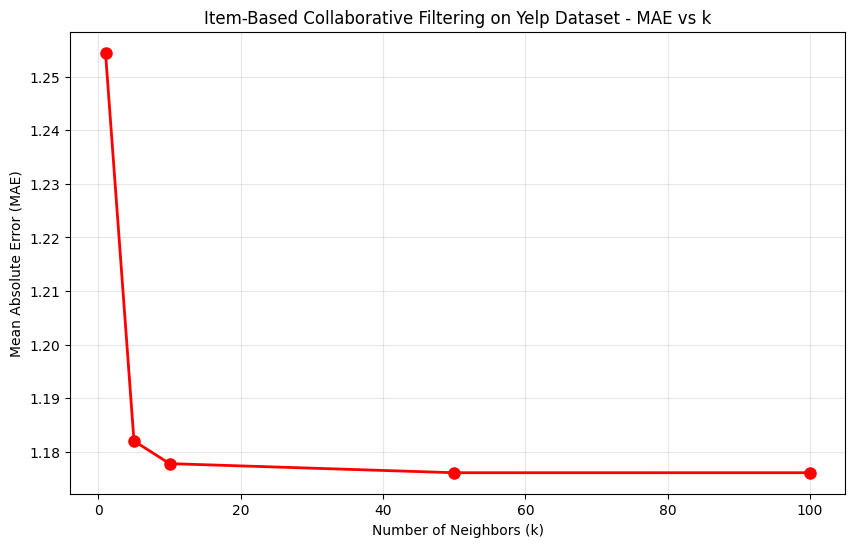


Summary of Results for Yelp Dataset:
k	MAE
---------------
1	1.2544
5	1.1820
10	1.1778
50	1.1761
100	1.1761


In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import time
from scipy import sparse
import matplotlib.pyplot as plt

# Load and split Yelp data
def load_and_split_yelp_data():
    ratings_df = pd.read_csv('ratings.csv')
    ratings_df['Date'] = pd.to_datetime(ratings_df['Date'])
    ratings_df = ratings_df.sort_values(['User ID', 'Date'])

    unique_users = sorted(ratings_df['User ID'].unique())
    unique_businesses = sorted(ratings_df['Business ID'].unique())

    user_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
    business_to_idx = {business_id: idx for idx, business_id in enumerate(unique_businesses)}

    train_data = []
    test_data = []

    for user_id in unique_users:
        user_ratings = ratings_df[ratings_df['User ID'] == user_id].copy()
        n_ratings = len(user_ratings)

        if n_ratings == 1:
            train_data.extend(user_ratings.values.tolist())
        else:
            n_train = int(np.floor(n_ratings * 0.8))
            train_ratings = user_ratings.iloc[:n_train]
            test_ratings = user_ratings.iloc[n_train:]
            train_data.extend(train_ratings.values.tolist())
            test_data.extend(test_ratings.values.tolist())

    train_df = pd.DataFrame(train_data, columns=['User ID', 'Business ID', 'Rating', 'Date'])
    test_df = pd.DataFrame(test_data, columns=['User ID', 'Business ID', 'Rating', 'Date'])

    return train_df, test_df, user_to_idx, business_to_idx, len(unique_users), len(unique_businesses)

# Create sparse matrices
def create_sparse_matrices(train_df, test_df, user_to_idx, business_to_idx, num_users, num_businesses):
    train_user_indices = [user_to_idx[uid] for uid in train_df['User ID']]
    train_business_indices = [business_to_idx[bid] for bid in train_df['Business ID']]
    train_ratings = train_df['Rating'].values

    sp_training = sparse.csr_matrix(
        (train_ratings, (train_user_indices, train_business_indices)),
        shape=(num_users, num_businesses),
        dtype=np.float64
    )

    test_user_indices = [user_to_idx[uid] for uid in test_df['User ID']]
    test_business_indices = [business_to_idx[bid] for bid in test_df['Business ID']]
    test_ratings = test_df['Rating'].values

    sp_test = sparse.csr_matrix(
        (test_ratings, (test_user_indices, test_business_indices)),
        shape=(num_users, num_businesses),
        dtype=np.float64
    )

    return sp_training, sp_test

def compute_item_similarities(sp_training, num_businesses):
    start = time.time()
    sp_training_copy = sp_training.copy()

    for u in range(sp_training_copy.shape[0]):
        user_ratings = sp_training_copy.getrow(u)
        nonzero_indices = user_ratings.nonzero()[1]
        if len(nonzero_indices) > 0:
            ratings = user_ratings.data
            mean_rating = ratings.mean()
            for idx, item_idx in enumerate(nonzero_indices):
                sp_training_copy[u, item_idx] -= mean_rating

    normalized_matrix = sp_training_copy.toarray()
    item_similarity = np.zeros((num_businesses, num_businesses))

    for i in range(num_businesses):
        for j in range(i, num_businesses):
            item_i = normalized_matrix[:, i]
            item_j = normalized_matrix[:, j]
            common_users = (item_i != 0) & (item_j != 0)
            if np.sum(common_users) > 0:
                ratings_i = item_i[common_users]
                ratings_j = item_j[common_users]
                norm_i = np.linalg.norm(ratings_i)
                norm_j = np.linalg.norm(ratings_j)
                if norm_i > 0 and norm_j > 0:
                    similarity = np.dot(ratings_i, ratings_j) / (norm_i * norm_j)
                    item_similarity[i, j] = similarity
                    item_similarity[j, i] = similarity

    return item_similarity

def compute_user_means(sp_training):
    num_users = sp_training.shape[0]
    user_means = np.zeros(num_users)
    for u in range(num_users):
        user_ratings = sp_training.getrow(u)
        if user_ratings.nnz > 0:
            user_means[u] = user_ratings.data.mean()
    return user_means

# Predict 
def predict(user, item, k, sp_training, item_similarity, user_means):
    user_ratings = sp_training.getrow(user)
    rated_items = user_ratings.nonzero()[1]

    if len(rated_items) == 0:
        return user_means[user] if user_means[user] > 0 else 3.0

    similarities = item_similarity[item, rated_items]
    actual_ratings = user_ratings.data

    if len(similarities) > 0:
        sorted_indices = np.argsort(similarities)[::-1]
        k = min(k, len(sorted_indices))
        top_k_indices = sorted_indices[:k]
        top_k_similarities = similarities[top_k_indices]
        top_k_ratings = actual_ratings[top_k_indices]
        positive_sim_mask = top_k_similarities > 0

        if np.sum(positive_sim_mask) > 0:
            top_k_similarities = top_k_similarities[positive_sim_mask]
            top_k_ratings = top_k_ratings[positive_sim_mask]
            if np.sum(np.abs(top_k_similarities)) > 0:
                prediction = np.dot(top_k_similarities, top_k_ratings) / np.sum(np.abs(top_k_similarities))
                return prediction

    return user_means[user] if user_means[user] > 0 else 3.0

# Compute MAE
def computeMAE(k, sp_training, sp_test, item_similarity, user_means):
    MAE = 0.0
    rows, cols = sp_test.nonzero()
    for j in range(len(rows)):
        actual = sp_test[rows[j], cols[j]]
        predicted = predict(rows[j], cols[j], k, sp_training, item_similarity, user_means)
        MAE += abs(actual - predicted)
    MAE /= len(rows)
    return MAE
# test item_based cf
def test_item_based_cf():
    train_df, test_df, user_to_idx, business_to_idx, num_users, num_businesses = load_and_split_yelp_data()
    sp_training, sp_test = create_sparse_matrices(train_df, test_df, user_to_idx, business_to_idx, num_users, num_businesses)
    item_similarity = compute_item_similarities(sp_training, num_businesses)
    user_means = compute_user_means(sp_training)

    k_values = [1, 5, 10, 50, 100]
    MAEs = []

    for k in k_values:
        MAE = computeMAE(k, sp_training, sp_test, item_similarity, user_means)
        MAEs.append(MAE)

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, MAEs, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Item-Based Collaborative Filtering on Yelp Dataset - MAE vs k')
    plt.grid(True, alpha=0.3)
    plt.show()
    print("\nSummary of Results for Yelp Dataset:")
    print("k\tMAE")
    print("-" * 15)
    for k, mae in zip(k_values, MAEs):
        print(f"{k}\t{mae:.4f}")

    return MAEs

if __name__ == '__main__':
    MAEs = test_item_based_cf()

